## **Bibliotecas**

In [0]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

## **Funções**

In [0]:
%run ./functions

## **Parâmetros**

In [0]:
silver_path = f'{lake_path}/silver/tb_silver_breweries'

## **Tratamento**

In [0]:
# Leitura da Tabela Silver
df_breweries = (spark.read.format('delta').load(silver_path))

## **Agregação**

In [0]:
# Create an aggregated view with the quantity of breweries per type and location
df_breweries_agg = df_breweries.groupBy('country', 'brewery_type').agg(sum(lit(1)).alias('breweries_quantity'))

In [0]:
# COLUNAS QUE GERAM A CHAVE ÚNICA (Utilizada na função "unique_key_gen" com o método transform)
unique_key_cols = ['country', 'brewery_type']

df_breweries_key = (df_breweries_agg
    .transform(unique_key_gen, unique_key_cols))

# VALIDAÇÃO DA UNICIDADE DAS CHAVES
key_validation(dataframe=df_breweries_key, chave='chave')
df_breweries_final = (df_breweries_key.drop('chave'))

In [0]:
df_breweries_key.display()

country,brewery_type,breweries_quantity,chave
Austria,brewpub,1,Austriabrewpub
Austria,nano,2,Austrianano
Austria,large,9,Austrialarge
Austria,bar,2,Austriabar
South Korea,micro,5,SouthKoreamicro
South Korea,brewpub,56,SouthKoreabrewpub
England,large,1,Englandlarge
England,taproom,11,Englandtaproom
England,micro,40,Englandmicro
England,brewpub,10,Englandbrewpub


## **Visualização da Agregação**

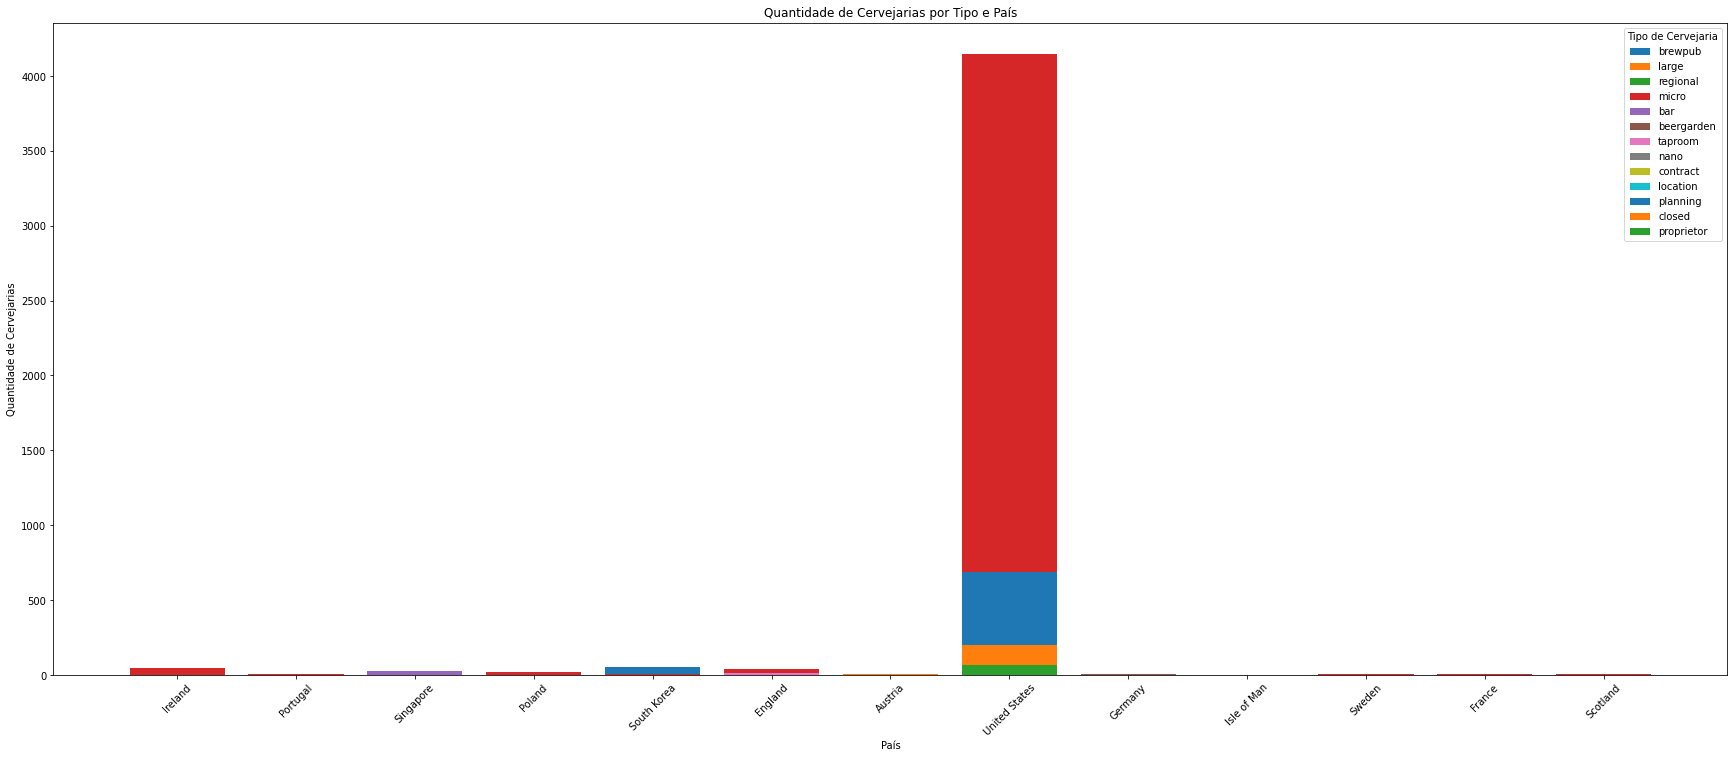

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Convertendo o DataFrame do PySpark para um DataFrame do Pandas
df_pandas = df_breweries_final.toPandas()

# Criando um gráfico de barras
plt.figure(figsize=(30, 12))

# Usando um gráfico de barras agrupadas - O loop itera sobre cada tipo de cervejaria e plota a quantidade de cervejarias por país.
for brewery_type in df_pandas['brewery_type'].unique():
    subset = df_pandas[df_pandas['brewery_type'] == brewery_type]
    plt.bar(subset['country'], subset['breweries_quantity'], label=brewery_type)

# Configurando o gráfico
plt.title('Quantidade de Cervejarias por Tipo e País')
plt.xlabel('País')
plt.ylabel('Quantidade de Cervejarias')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Cervejaria')
plt.show()

## **Upsert na Tabela**

In [0]:
# Criação da Temp View para Upsert
df_breweries_final.createOrReplaceTempView('view_breweries_agg')

In [0]:
%sql
SELECT * FROM view_breweries_agg

country,brewery_type,breweries_quantity
South Korea,micro,5
South Korea,brewpub,56
Sweden,micro,6
England,large,1
England,taproom,11
England,micro,40
England,brewpub,10
France,micro,3
Portugal,brewpub,7
Portugal,micro,7


In [0]:
%sql
MERGE INTO tb_gold_breweries as TARGET
USING view_breweries_agg as SOURCE
ON TARGET.country = SOURCE.country
AND TARGET.brewery_type = SOURCE.brewery_type
WHEN MATCHED THEN
  UPDATE SET  
    breweries_quantity = source.breweries_quantity
WHEN NOT MATCHED
  THEN INSERT (
    country,
    brewery_type,
    breweries_quantity    
        )
  VALUES (
    SOURCE.country,
    SOURCE.brewery_type,
    SOURCE.breweries_quantity
    )

num_affected_rows,num_updated_rows,num_deleted_rows,num_inserted_rows
42,0,0,42


In [0]:
spark.read.table('tb_gold_breweries').display()

country,brewery_type,breweries_quantity
Portugal,brewpub,7
Portugal,micro,7
South Korea,micro,5
South Korea,brewpub,56
Sweden,micro,6
Ireland,brewpub,9
Ireland,large,3
Ireland,regional,9
Ireland,micro,49
Germany,large,2
